In [1]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override()

df = pdr.get_data_yahoo("IBM", start="2019-01-01", end="2024-01-01")

[*********************100%%**********************]  1 of 1 completed


In [23]:
df.shape


(1258, 6)

In [2]:
reversed_df = df.iloc[::-1]

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features_fwd = scaler.fit_transform(df) 
scaled_features_bkwd = scaler.fit_transform(reversed_df) 

In [4]:
import numpy as np

def create_sequences(data, seq_length, prediction_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-prediction_length+1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length+prediction_length-1][4]  
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 5
predicition_length = 1
X_fwd, y_fwd = create_sequences(scaled_features_fwd, seq_length,predicition_length)
X_bkwd, y_bkwd = create_sequences(scaled_features_bkwd, seq_length, predicition_length)

In [5]:
split_fraction = 0.8
split = int(split_fraction * len(X_fwd))

X_train_fwd, X_test_fwd = X_fwd[:split], X_fwd[split:]
y_train_fwd, y_test_fwd = y_fwd[:split], y_fwd[split:]

X_train_bkwd, X_test_bkwd = X_bkwd[:split], X_bkwd[split:]
y_train_bkwd, y_test_bkwd = y_bkwd[:split], y_bkwd[split:]

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64  

#Forward
train_data = TensorDataset(torch.Tensor(X_train_fwd), torch.Tensor(y_train_fwd))
train_loader_fwd = DataLoader(train_data, shuffle=True, batch_size=batch_size)

test_data = TensorDataset(torch.Tensor(X_test_fwd), torch.Tensor(y_test_fwd))
test_loader_fwd = DataLoader(test_data, shuffle=False, batch_size=batch_size)

#Backward
train_data = TensorDataset(torch.Tensor(X_train_bkwd), torch.Tensor(y_train_bkwd))
train_loader_bkwd = DataLoader(train_data, shuffle=True, batch_size=batch_size)

test_data = TensorDataset(torch.Tensor(X_test_bkwd), torch.Tensor(y_test_bkwd))
test_loader_bkwd = DataLoader(test_data, shuffle=False, batch_size=batch_size)

## Simple RNN

In [7]:
import torch
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [8]:
def training_loop(num_epochs, device, optimizer, criterion, model, train_loader):
    loss_values =[]
    model.train()
    
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels.unsqueeze(-1))
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
    
        loss_values.append(loss.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return loss_values

### Forward and Backward Training

Running on CPU
Epoch [1/50], Loss: 0.4457
Epoch [2/50], Loss: 0.1924
Epoch [3/50], Loss: 0.1395
Epoch [4/50], Loss: 0.1366
Epoch [5/50], Loss: 0.1316
Epoch [6/50], Loss: 0.1161
Epoch [7/50], Loss: 0.0975
Epoch [8/50], Loss: 0.0510
Epoch [9/50], Loss: 0.0457
Epoch [10/50], Loss: 0.0166
Epoch [11/50], Loss: 0.0205
Epoch [12/50], Loss: 0.0220
Epoch [13/50], Loss: 0.0175
Epoch [14/50], Loss: 0.0237
Epoch [15/50], Loss: 0.0199
Epoch [16/50], Loss: 0.0192
Epoch [17/50], Loss: 0.0124
Epoch [18/50], Loss: 0.0228
Epoch [19/50], Loss: 0.0299
Epoch [20/50], Loss: 0.0175
Epoch [21/50], Loss: 0.0210
Epoch [22/50], Loss: 0.0182
Epoch [23/50], Loss: 0.0213
Epoch [24/50], Loss: 0.0126
Epoch [25/50], Loss: 0.0289
Epoch [26/50], Loss: 0.0141
Epoch [27/50], Loss: 0.0270
Epoch [28/50], Loss: 0.0251
Epoch [29/50], Loss: 0.0095
Epoch [30/50], Loss: 0.0065
Epoch [31/50], Loss: 0.0166
Epoch [32/50], Loss: 0.0131
Epoch [33/50], Loss: 0.0152
Epoch [34/50], Loss: 0.0117
Epoch [35/50], Loss: 0.0092
Epoch [36/50],

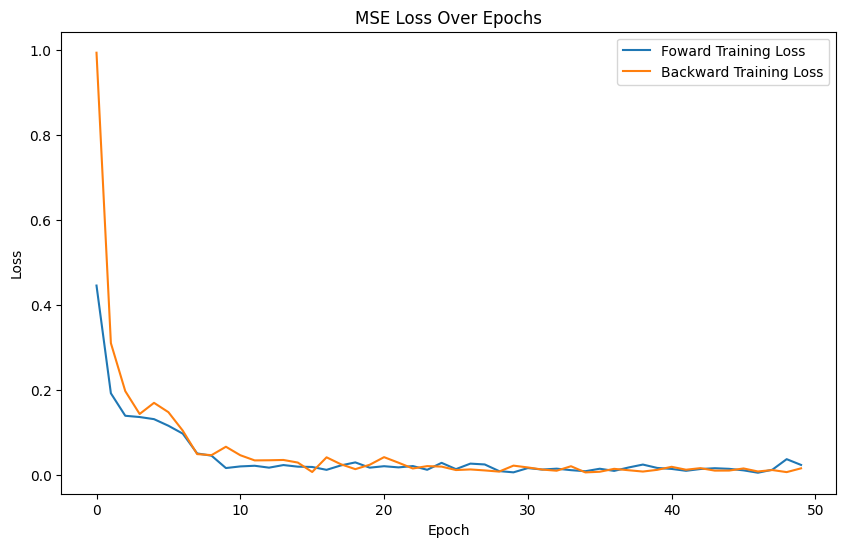

In [10]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    print("Running on GPU")
else: print("Running on CPU")

# Forward Model Initialization and Training 
model = SimpleRNN(input_size=6, hidden_size=20, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

loss_values_fwd = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=model,
    train_loader=train_loader_fwd
              )

# Backward Model Initialization and Training
model = SimpleRNN(input_size=6, hidden_size=20, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

loss_values_bkwd = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=model,
    train_loader=train_loader_bkwd
              )

plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd, label='Foward Training Loss')
plt.plot(loss_values_bkwd, label='Backward Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Loss Over Epochs')
plt.legend()
plt.show()

### Thoughts
So I have run this forward and backward at a number of different forecasting intervals (1 day, 1 week, 1 month, and 90 days). Although as I increase the distance of prediction the Loss does seem to increase, going forward and backward don't seem to indicate any difference in convergence rates. 

## Transformer

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

class Transformer(nn.Module):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import Transformer
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.transformer = Transformer(d_model=ninp, nhead=nhead, num_encoder_layers=nlayers,
                                       num_decoder_layers=nlayers, dim_feedforward=nhid, dropout=dropout)
        self.decoder = nn.Linear(ninp, ntoken)
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, tgt):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer(src, tgt, src_mask=self.src_mask)
        output = self.decoder(output)
        return output

In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [20]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    print("Running on GPU")
else: print("Running on CPU")

# Forward Model Initialization and Training 
model = Transformer(ninp=32,nhead=4, nhid=64, ).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

loss_values_fwd = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=model,
    train_loader=train_loader_fwd
              )

# Backward Model Initialization and Training
model = Transformer(input_size=6, hidden_size=20, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

loss_values_bkwd = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=model,
    train_loader=train_loader_bkwd
              )

plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd, label='Foward Training Loss')
plt.plot(loss_values_bkwd, label='Backward Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Loss Over Epochs')
plt.legend()
plt.show()

Running on CPU


TypeError: Transformer.__init__() got an unexpected keyword argument 'input_size'